# Unpaired Image-to-Image Translation using Cycle-GAN

Download horse2zebra dataset from https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip 

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [2]:
# Define some constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [3]:
# Load the horse2zebra dataset
PATH = 'datasets/horse2zebra'


In [4]:
# Preprocessing functions
def load_image(filename):
    image = load_img(filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    image = img_to_array(image)
    image = (image / 127.5) - 1.0  # Normalize the image to [-1, 1] range
    return image


In [5]:
def preprocess_image(image_file):
    image = load_image(image_file)
    return image


In [6]:
def load_image_files(path):
    return [os.path.join(path, fname) for fname in os.listdir(path)]


In [7]:
horse_files = load_image_files(PATH + '/trainA/')
zebra_files = load_image_files(PATH + '/trainB/')

In [8]:
train_horses = tf.data.Dataset.from_tensor_slices(horse_files).map(lambda x: tf.numpy_function(preprocess_image, [x], tf.float32)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_zebras = tf.data.Dataset.from_tensor_slices(zebra_files).map(lambda x: tf.numpy_function(preprocess_image, [x], tf.float32)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2025-07-18 14:52:42.609709: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-18 14:52:42.609891: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-18 14:52:42.609899: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1752830562.610503 311703617 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752830562.610606 311703617 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Define the CycleGAN model
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(LeakyReLU())
    return result

In [11]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
    x = Concatenate()([x, skip])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')
    x = Concatenate()([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return Model(inputs=[inp, tar], outputs=last)

In [13]:
generator_g = Generator()
generator_f = Generator()
discriminator_x = Discriminator()
discriminator_y = Discriminator()

In [14]:
# Losses
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [16]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [17]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [18]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [19]:
generator_g_optimizer = Adam(2e-4, beta_1=0.5)
generator_f_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = Adam(2e-4, beta_1=0.5)

In [20]:
# Training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        disc_real_x = discriminator_x([real_x, real_y], training=True)
        disc_real_y = discriminator_y([real_y, real_x], training=True)
        disc_fake_x = discriminator_x([real_x, fake_y], training=True)
        disc_fake_y = discriminator_y([real_y, fake_x], training=True)
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
        generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
        generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
        discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
        discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


In [21]:
# Training loop
EPOCHS = 40
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
    print(f'Epoch {epoch+1}/{EPOCHS} completed')


2025-07-18 14:53:43.837659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-18 15:19:00.325325: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/40 completed


2025-07-18 15:31:07.910157: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/40 completed
Epoch 3/40 completed


2025-07-18 18:45:40.822785: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/40 completed
Epoch 5/40 completed
Epoch 6/40 completed
Epoch 7/40 completed


2025-07-18 19:50:56.153876: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/40 completed
Epoch 9/40 completed
Epoch 10/40 completed
Epoch 11/40 completed
Epoch 12/40 completed
Epoch 13/40 completed
Epoch 14/40 completed
Epoch 15/40 completed


2025-07-18 21:52:39.283438: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/40 completed
Epoch 17/40 completed
Epoch 18/40 completed
Epoch 19/40 completed
Epoch 20/40 completed
Epoch 21/40 completed
Epoch 22/40 completed
Epoch 23/40 completed
Epoch 24/40 completed
Epoch 25/40 completed
Epoch 26/40 completed
Epoch 27/40 completed
Epoch 28/40 completed
Epoch 29/40 completed
Epoch 30/40 completed
Epoch 31/40 completed


2025-07-19 09:35:55.486070: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/40 completed
Epoch 33/40 completed
Epoch 34/40 completed
Epoch 35/40 completed
Epoch 36/40 completed
Epoch 37/40 completed
Epoch 38/40 completed
Epoch 39/40 completed
Epoch 40/40 completed


In [22]:
# Display sample results
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Translated Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(array_to_img(display_list[i]))
    plt.axis('off')
    plt.show()

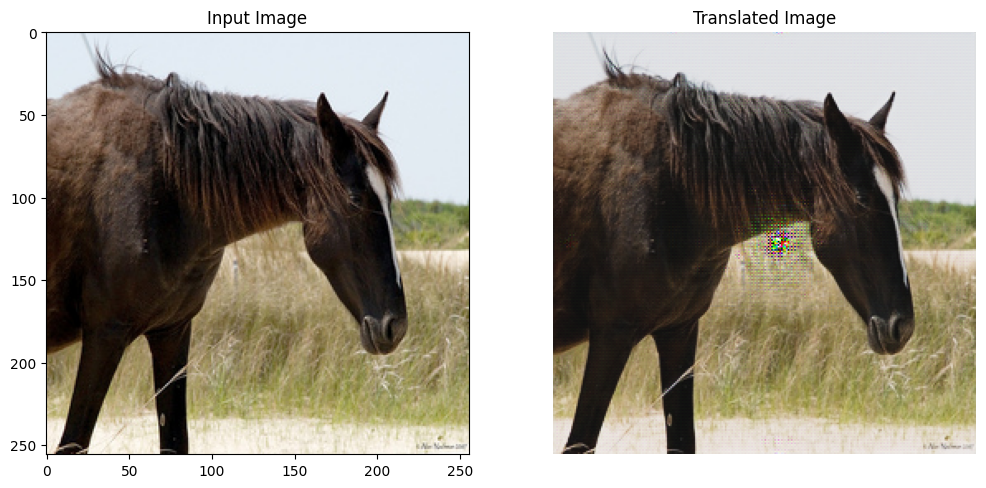

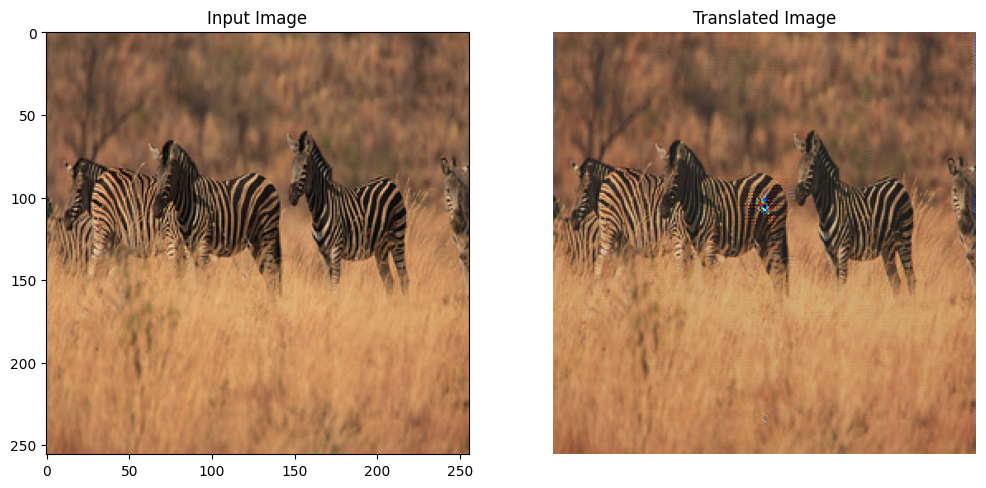

In [30]:
sample_horse = next(iter(train_horses.take(1)))
sample_zebra = next(iter(train_zebras.take(1)))
generate_images(generator_g, sample_horse)
generate_images(generator_f, sample_zebra)